# Named Entity Recognition (NER)

## Imports ##

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Preprocessing

In [11]:
def read_file(filename):
    with open(filename, "r") as file:
        text = file.readlines()
    return text

def process_text(text):
    X = []
    Y = []
    sentenceX = []
    sentenceY = []
    for line in text:
        split = line.split(" ")
        if len(split) > 1:
            sentenceX.append(split[0])
            sentenceY.append(split[1].replace("\n", ""))
        else:
            X.append(sentenceX)
            Y.append(sentenceY)
            sentenceX = []
            sentenceY = []
    return X, Y

text = read_file("/kaggle/input/dataset/train.txt")
test_text = read_file("/kaggle/input/dataset/test.txt")
X_t, Y_t = process_text(text)
X_test, Y_test = process_text(test_text)

X_train, X_val, Y_train, Y_val = train_test_split(X_t, Y_t, test_size=0.16666, random_state=42)

## Loading Glove Embeddings

In [12]:
def load_glove_embeddings(embedding_path):
    embeddings_index = {}
    with open(embedding_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [13]:
word_index = {}
tag2id = {}
id2tag = {}
for sentence in X_t:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index) + 1
            
for sentence in X_test:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index) + 1

for i in range(len(Y_t)):
    for y in Y_t[i]:
        if y not in tag2id:
            tag2id[y] = len(tag2id)

for i in range(len(Y_test)):
    for y in Y_test[i]:
        if y not in tag2id:
            tag2id[y] = len(tag2id)
for obj in tag2id:
    id2tag[tag2id[obj]] = obj
word_index['<UNK>'] = len(word_index)

## Creating Embedding Matrix

In [14]:
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)
    return embedding_matrix

## LSTM Implementation ##

`self.word_embeddings` is an instance of `nn.Embedding` and is initialized with pre-trained word embeddings which has glove embeddings. The size of the word embedding layer is typically determined by the size of the vocabulary and the desired size of the dense vectors.

`self.lstm` is a bidirectional LSTM layer that takes as input the word embeddings for the entire sentence and produces the hidden states for each token in the sentence. The output of the LSTM layer is then passed to the linear layer `self.hidden2tag` to obtain the final scores for each tag.


`self.hidden2tag` is a linear layer in the PyTorch neural network module, which takes as input the concatenated hidden state of the forward and backward LSTM layers, where hidden_dim is the number of features in the LSTM hidden state and tagset_size is the number of output tags.

In [15]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings=None):
        super().__init__()
        if pretrained_embeddings is not None:
            self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = torch.nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores
def prepare_sequence(seq, to_idx):
    idxs = [to_idx[w] if w in to_idx else to_idx['<UNK>'] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)
def flatten(lst):
    flattened = []
    for item in lst:
        if isinstance(item, list):
            flattened.extend(flatten(item))
        else:
            flattened.append(item)
    return flattened

## Training the model

In [16]:
def train(EMBEDDING_DIM,HIDDEN_DIM,LR,EPOCHS):

    #loading glove_embeddings
    embedding_path = '/kaggle/input/glove-embeddings/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
    glove_embeddings = load_glove_embeddings(embedding_path)
    
    #creating embedding_matrix
    embedding_matrix = create_embedding_matrix(word_index, glove_embeddings, EMBEDDING_DIM)
    embedding_matrix = torch.tensor(embedding_matrix).to(torch.float32)
    
    # Create model instance
    model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_index), len(tag2id), pretrained_embeddings=embedding_matrix)

    model.cuda()

    # Define loss function and optimizer
    criterion = nn.NLLLoss() # Negative Log Likelihood Loss
    optimizer = optim.Adam(model.parameters(), lr=LR) # Adam Optimizer

    # Training loop
    for epoch in range(EPOCHS):
        total_loss = 0.0

        for i in range(len(X_train)):
            sentence = X_train[i]
            tags = Y_train[i]
            # Clear gradients
            model.zero_grad()

            # Forward pass
            sentence = prepare_sequence(sentence, word_index)
            targets = prepare_sequence(tags, tag2id)

            sentence = sentence.cuda()
            targets = targets.cuda()
            tag_scores = model(sentence)

            # Calculate loss
            loss = criterion(tag_scores, targets)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate total loss
            total_loss += loss.item()

        # Print average loss for epoch
        avg_loss = total_loss / len(X_train)
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}')
        
    return model

## Prediction and Scores

In [17]:
def predict(X_test,Y_test,model):
    Y_pred = []
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(X_test)):
            sentence = X_test[i]
            tags = Y_test[i]
            sentence = prepare_sequence(sentence, word_index)
            targets = prepare_sequence(tags, tag2id)
            sentence = sentence.cuda()
            targets = targets.cuda()
            tag_scores = model(sentence)

            _, predicted_tags = torch.max(tag_scores.data, 1)
            total += targets.size(0)
            correct += (predicted_tags == targets).sum().item()

            Y1 = [id2tag[t.item()] for t in predicted_tags]
            Y_pred.append(Y1)
    accuracy = 100 * correct / total
    
    return Y_pred,accuracy
def get_scores(predY, trueY):
    from sklearn.metrics import f1_score
    trueY_O = [i for i, x in enumerate(trueY) if x == "O"]
    predY = [predY[i] for i in range(len(predY)) if i not in trueY_O]
    trueY = [trueY[i] for i in range(len(trueY)) if i not in trueY_O]

    micro_F1 = f1_score(trueY, predY, average="micro")
    macro_F1 = f1_score(trueY, predY, average="macro")
    average_F1 = (f1_score(trueY, predY, average="micro") + f1_score(trueY, predY, average="macro")) / 2
    
    return micro_F1,macro_F1,average_F1

In [18]:
LR = 0.01
EPOCHS = 20

EMBEDDING_DIMS = [50,100,200,300]
HIDDEN_DIMS = [50,100,200,300]
micro_train_arr = []
macro_train_arr = []
average_train_arr = []
micro_val_arr = []
macro_val_arr = []
average_val_arr = []
train_accu_arr = []
val_accu_arr = []

for e in EMBEDDING_DIMS:
    micro_train = []
    macro_train = []
    average_train = []
    micro_val = []
    macro_val = []
    average_val = []
    train_accu = []
    val_accu = []
    for h in HIDDEN_DIMS:
        model = train(e,h,LR,EPOCHS)
        Y_train_pred,train_acc = predict(X_train,Y_train,model)
        Y_val_pred,val_acc  = predict(X_val,Y_val,model)
        Y_train_flat = flatten(Y_train)
        Y_train_pred = flatten(Y_train_pred)
        Y_val_flat = flatten(Y_val)
        Y_val_pred = flatten(Y_val_pred)
        micro_F1,macro_F1,average_F1 = get_scores(Y_train_pred,Y_train_flat)
        micro_F1_val,macro_F1_val,average_F1_val = get_scores(Y_val_pred,Y_val_flat)
        micro_train.append(micro_F1)
        macro_train.append(macro_F1)
        average_train.append(average_F1)
        micro_val.append(micro_F1_val)
        macro_val.append(macro_F1_val)
        average_val.append(average_F1_val)
        train_accu.append(train_acc)
        val_accu.append(val_acc)
        
    micro_train_arr.append(micro_train)
    macro_train_arr.append(macro_train)
    average_train_arr.append(average_train)
    micro_val_arr.append(micro_val)
    macro_val_arr.append(macro_val)
    average_val_arr.append(average_val)
    train_accu_arr.append(train_accu)
    val_accu_arr.append(val_accu)

Epoch 1/20, Loss: 0.4839
Epoch 2/20, Loss: 0.3447
Epoch 3/20, Loss: 0.3099
Epoch 4/20, Loss: 0.2893
Epoch 5/20, Loss: 0.2762
Epoch 6/20, Loss: 0.2651
Epoch 7/20, Loss: 0.2561
Epoch 8/20, Loss: 0.2477
Epoch 9/20, Loss: 0.2435
Epoch 10/20, Loss: 0.2374
Epoch 11/20, Loss: 0.2325
Epoch 12/20, Loss: 0.2309
Epoch 13/20, Loss: 0.2287
Epoch 14/20, Loss: 0.2217
Epoch 15/20, Loss: 0.2200
Epoch 16/20, Loss: 0.2182
Epoch 17/20, Loss: 0.2176
Epoch 18/20, Loss: 0.2136
Epoch 19/20, Loss: 0.2113
Epoch 20/20, Loss: 0.2094
Epoch 1/20, Loss: 0.4800
Epoch 2/20, Loss: 0.3479
Epoch 3/20, Loss: 0.3100
Epoch 4/20, Loss: 0.2896
Epoch 5/20, Loss: 0.2732
Epoch 6/20, Loss: 0.2645
Epoch 7/20, Loss: 0.2528
Epoch 8/20, Loss: 0.2488
Epoch 9/20, Loss: 0.2372
Epoch 10/20, Loss: 0.2351
Epoch 11/20, Loss: 0.2297
Epoch 12/20, Loss: 0.2314
Epoch 13/20, Loss: 0.2253
Epoch 14/20, Loss: 0.2207
Epoch 15/20, Loss: 0.2189
Epoch 16/20, Loss: 0.2189
Epoch 17/20, Loss: 0.2160
Epoch 18/20, Loss: 0.2144
Epoch 19/20, Loss: 0.2119
Epoc

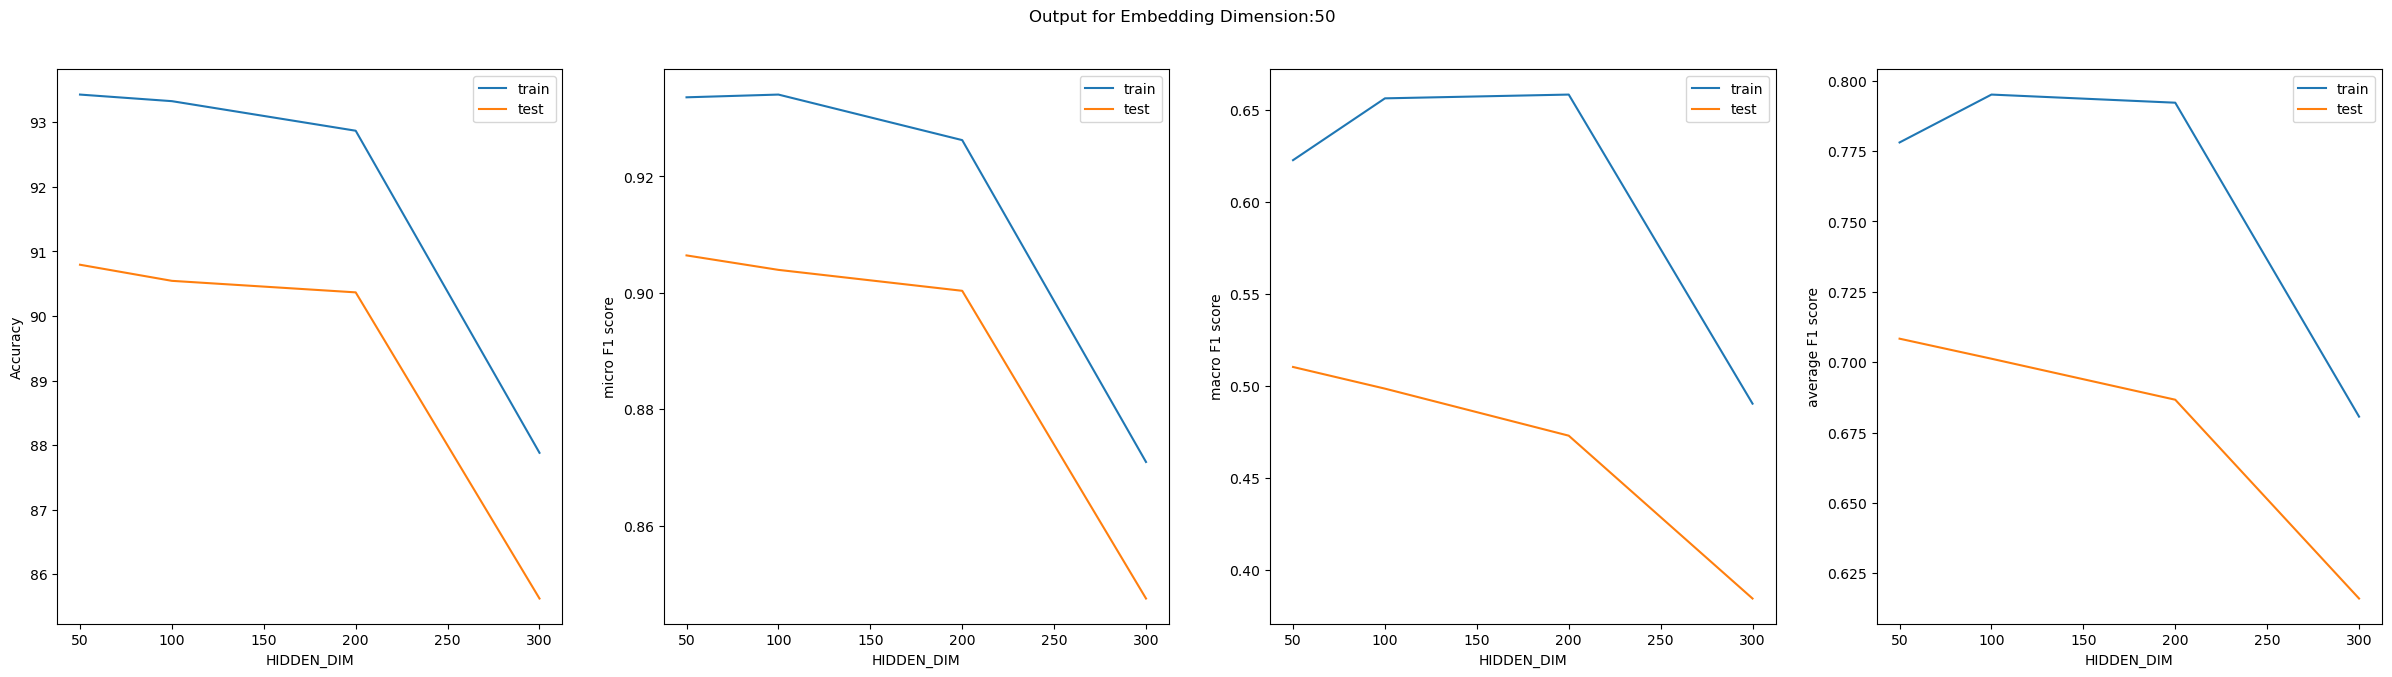

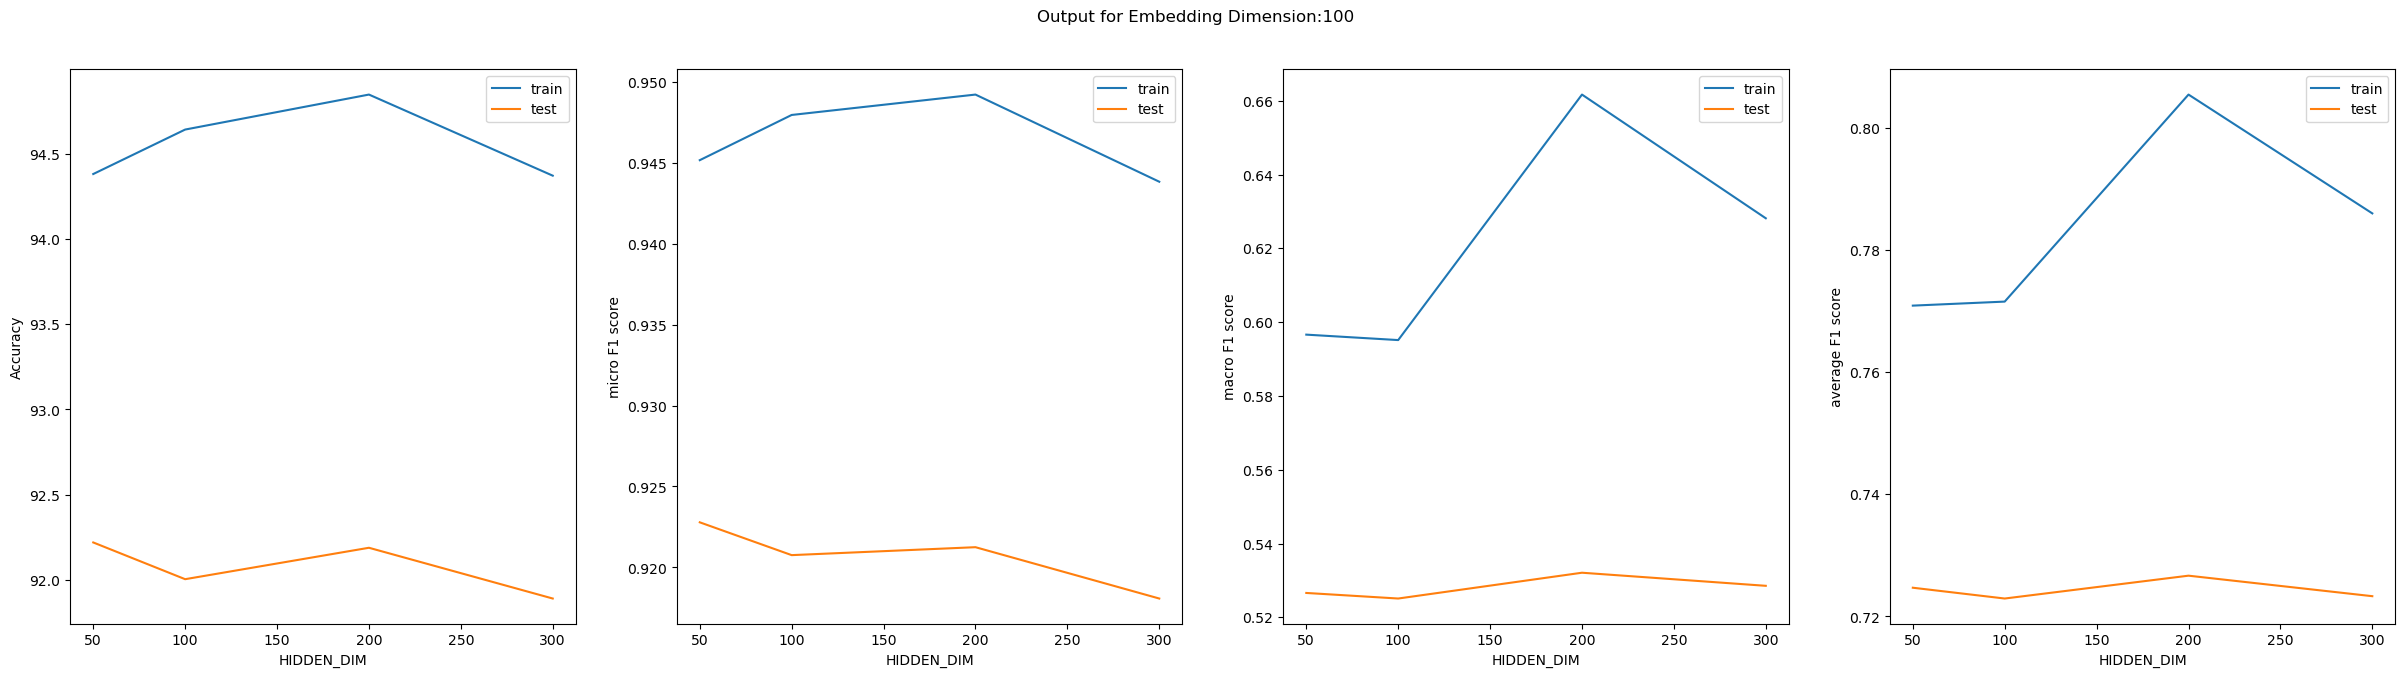

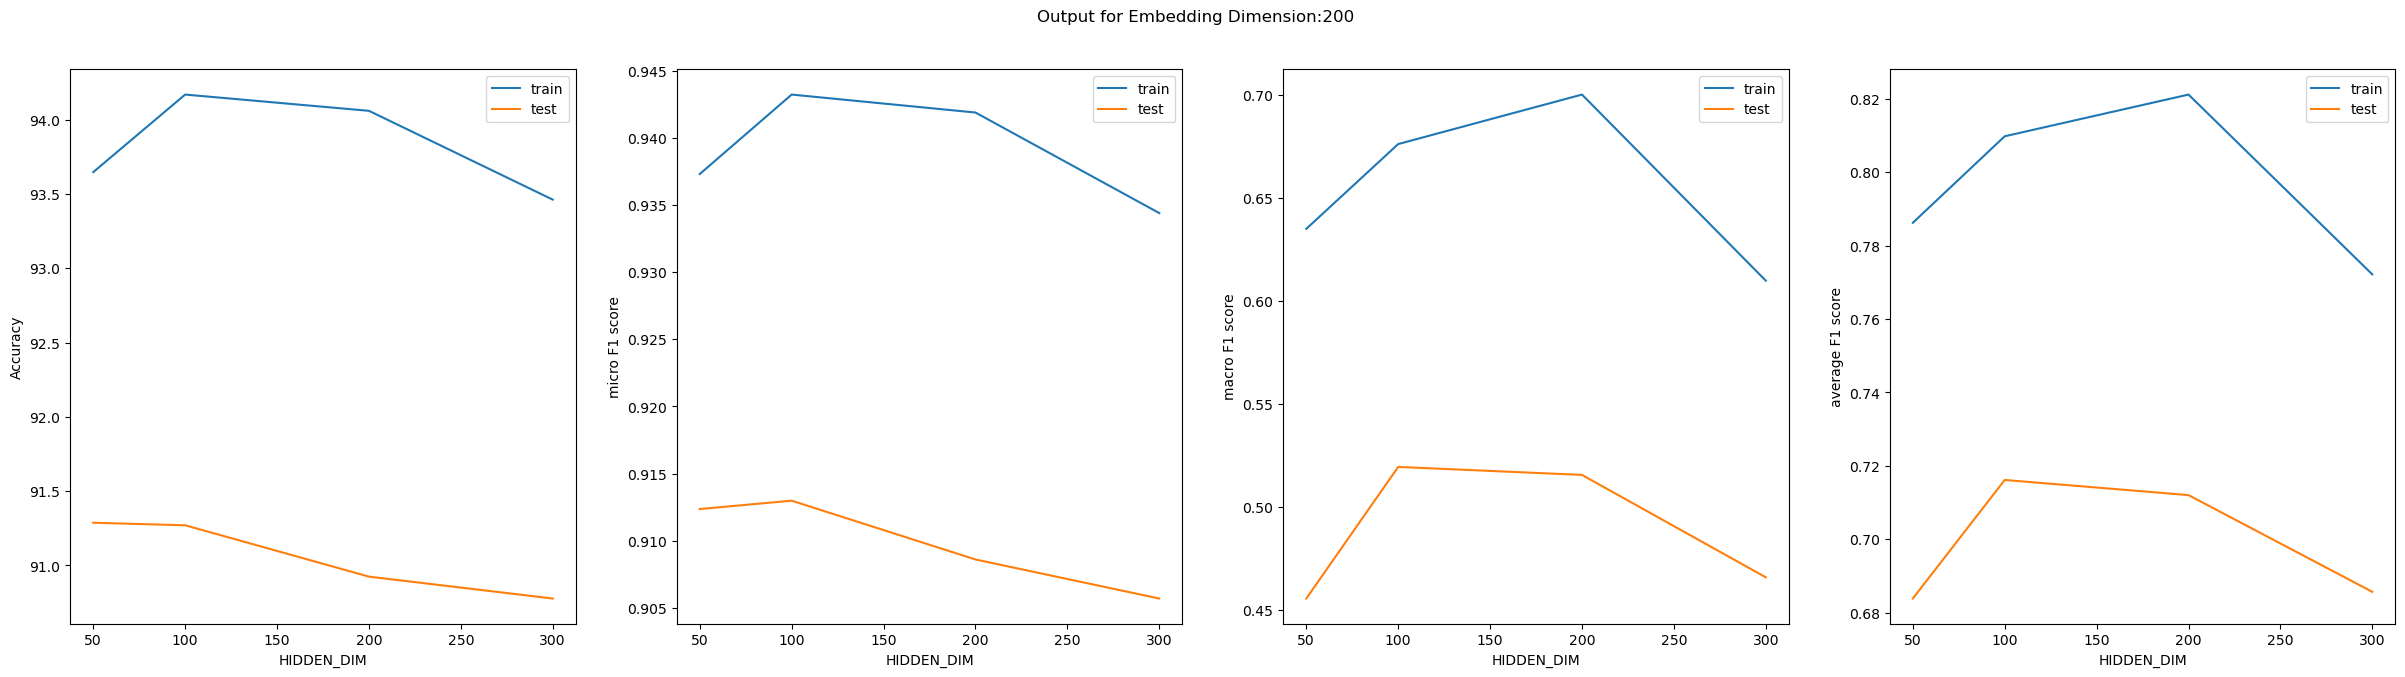

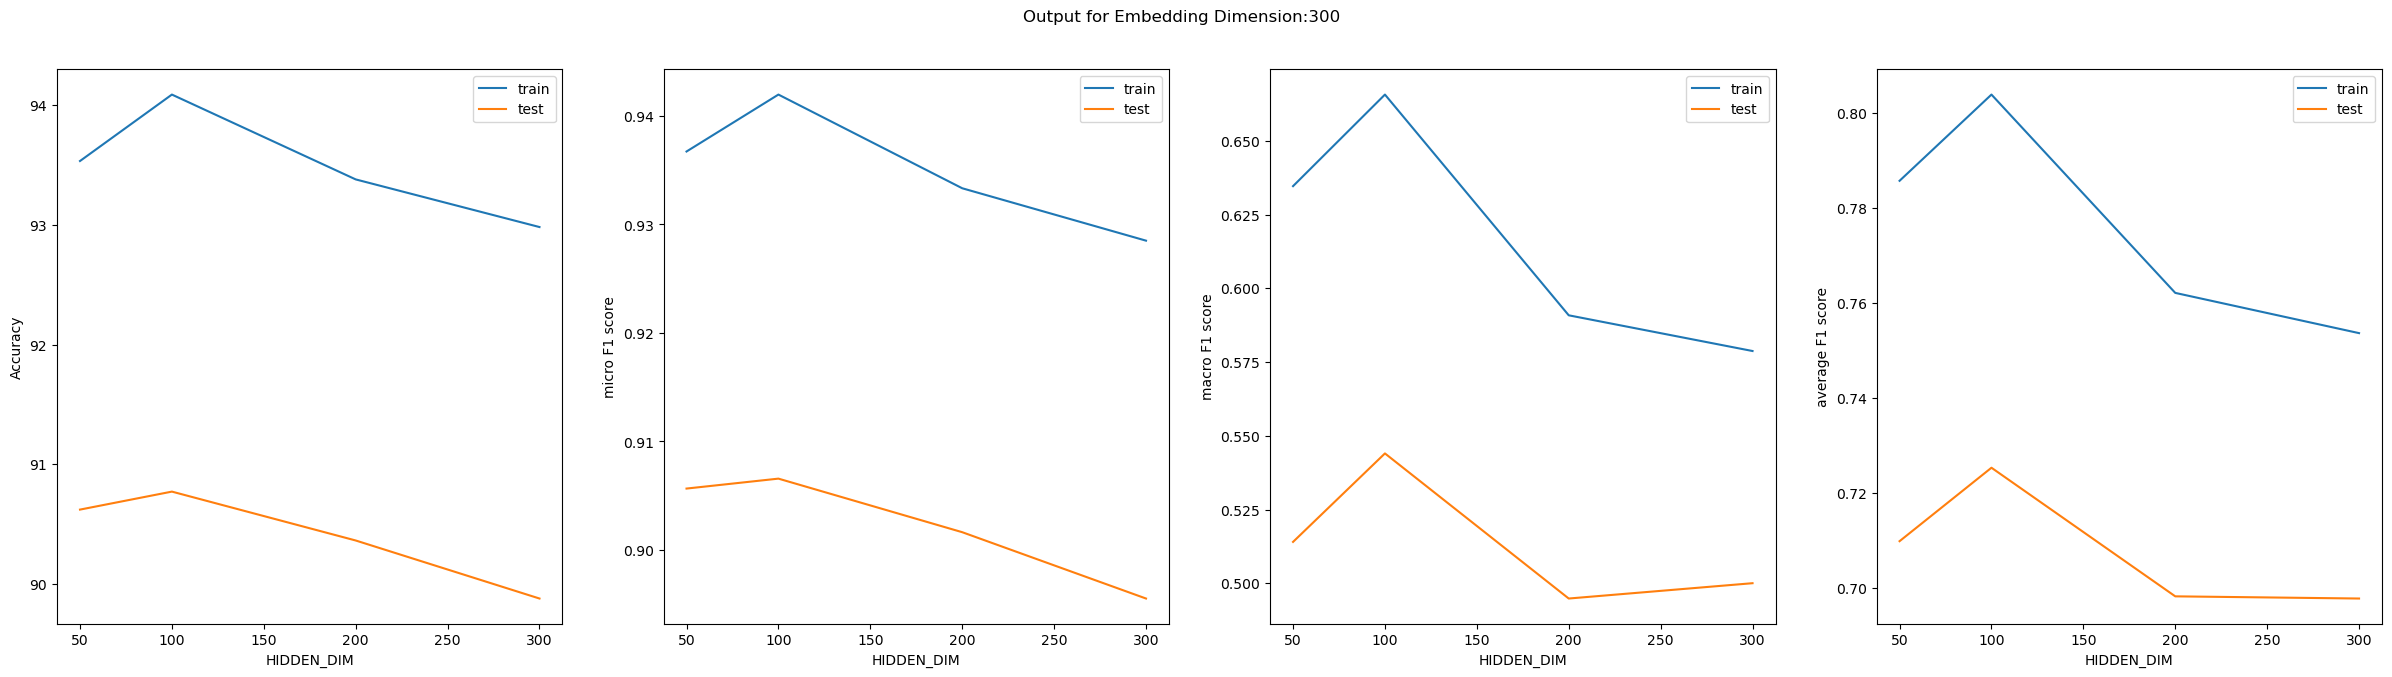

In [19]:
for i in range(4):

    fig1 = plt.figure(figsize = (30,30))
    ax1 = fig1.add_subplot(4,4,1)
    ax2 = fig1.add_subplot(4,4,2)
    ax3 = fig1.add_subplot(4,4,3)
    ax4 = fig1.add_subplot(4,4,4)
    fig1.suptitle('Output for Embedding Dimension:{}'.format(EMBEDDING_DIMS[i]))
    lab = ['train','test']

    ax1.plot(HIDDEN_DIMS,train_accu_arr[i])
    ax1.plot(HIDDEN_DIMS,val_accu_arr[i])
    ax1.set(xlabel='HIDDEN_DIM', ylabel='Accuracy')
    ax1.legend(lab)

    ax2.plot(HIDDEN_DIMS,micro_train_arr[i])
    ax2.plot(HIDDEN_DIMS,micro_val_arr[i])
    ax2.set(xlabel='HIDDEN_DIM', ylabel='micro F1 score')
    ax2.legend(lab)

    ax3.plot(HIDDEN_DIMS,macro_train_arr[i])
    ax3.plot(HIDDEN_DIMS,macro_val_arr[i])
    ax3.set(xlabel='HIDDEN_DIM', ylabel='macro F1 score')
    ax3.legend(lab)

    ax4.plot(HIDDEN_DIMS,average_train_arr[i])
    ax4.plot(HIDDEN_DIMS,average_val_arr[i])
    ax4.set(xlabel='HIDDEN_DIM', ylabel='average F1 score')
    ax4.legend(lab)
    plt.subplots_adjust(top=0.96)
    
    



plt.show()

**It can be observed that EMBEDDING_DIM=100 and HIDDEN_DIM = 200 seems to be better.**

In [21]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 200
LR = 0.01
EPOCHS = 20
model = train(EMBEDDING_DIM,HIDDEN_DIM,LR,EPOCHS)

Y_train_pred,train_acc = predict(X_train,Y_train,model)
Y_val_pred,val_acc = predict(X_val,Y_val,model)
Y_test_pred,test_acc  = predict(X_test,Y_test,model)
Y_train_flat = flatten(Y_train)
Y_train_pred = flatten(Y_train_pred)
Y_test_flat = flatten(Y_test)
Y_test_pred = flatten(Y_test_pred)
Y_val_flat = flatten(Y_val)
Y_val_pred = flatten(Y_val_pred)
micro_F1,macro_F1,average_F1 = get_scores(Y_train_pred,Y_train_flat)
micro_F1_test,macro_F1_test,average_F1_test = get_scores(Y_test_pred,Y_test_flat)
micro_F1_val,macro_F1_val,average_F1_val = get_scores(Y_val_pred,Y_val_flat)

print("\n")
print("Scores on Training Data:")
print("Micro F1 score: ", micro_F1)
print("Macro F1 score: ", macro_F1)
print("Average F1 score: ",average_F1)
print("Accuracy: ", train_acc)

print("\n")
print("Scores on Validation Data:")
print("Micro F1 score: ", micro_F1_val)
print("Macro F1 score: ", macro_F1_val)
print("Average F1 score: ",average_F1_val)
print("Accuracy: ", val_acc)

print("\n")
print("Scores on Test Data:")
print("Micro F1 score: ", micro_F1_test)
print("Macro F1 score: ", macro_F1_test)
print("Average F1 score: ",average_F1_test)
print("Accuracy: ", test_acc)

Epoch 1/20, Loss: 0.4358
Epoch 2/20, Loss: 0.3191
Epoch 3/20, Loss: 0.2808
Epoch 4/20, Loss: 0.2597
Epoch 5/20, Loss: 0.2497
Epoch 6/20, Loss: 0.2359
Epoch 7/20, Loss: 0.2310
Epoch 8/20, Loss: 0.2230
Epoch 9/20, Loss: 0.2164
Epoch 10/20, Loss: 0.2111
Epoch 11/20, Loss: 0.2122
Epoch 12/20, Loss: 0.2091
Epoch 13/20, Loss: 0.2044
Epoch 14/20, Loss: 0.1961
Epoch 15/20, Loss: 0.2008
Epoch 16/20, Loss: 0.1963
Epoch 17/20, Loss: 0.1906
Epoch 18/20, Loss: 0.1874
Epoch 19/20, Loss: 0.1907
Epoch 20/20, Loss: 0.1882


Scores on Training Data:
Micro F1 score:  0.9456064215094463
Macro F1 score:  0.6453163182907482
Average F1 score:  0.7954613699000972
Accuracy:  94.58131429057214


Scores on Validation Data:
Micro F1 score:  0.9199738476626349
Macro F1 score:  0.5269121369190366
Average F1 score:  0.7234429922908358
Accuracy:  92.09511932430134


Scores on Test Data:
Micro F1 score:  0.9145083379857757
Macro F1 score:  0.5336768869162866
Average F1 score:  0.7240926124510312
Accuracy:  91.66051037